# Steam players data.
1. Games to zebrane dane o grach jakie ktoś posiada i ile w nie grał.
2. Info to dane z pierwszej strony profilu steama.
3. Reviews to recenzje.
4. Groups to grupy do których należy.
5. Clustered_games to moje wstępne poklastrowanie tak, żeby nie babrać się z 50k+ grami.
6. steam_top_1k to ręcznie wyciągnięte przeze mnie najpopularniejsze gry. Teraz tego używam bo pierwsze clustered_games było problematyczne.

# DB connection / games_data.csv from steam_players db

In [10]:
from sqlalchemy import create_engine

server = 'localhost'
database = 'steam_players'
# username = '<your_username>'
# password = '<your_password>'
driver = 'ODBC Driver 17 for SQL Server'

engine = create_engine(f'mssql://{server}:1433/{database}?trusted_connection=yes&driver={driver}')

In [11]:
from query_generators.generators import query_for_gamecodes
import polars as pl

pl.read_database(query=query_for_gamecodes(code_list=[18723, 52848]), connection=engine.connect())

profile_code,game_0,game_1
i64,i64,i64
212301,15,0
212435,1219,0
212486,0,0
212561,0,0
212619,719,0
…,…,…
99742,0,0
168498,0,1409
2607808,0,1


In [2]:
# columns: hours_on_record, hours_last_2_weeks, profile_code, game_name
import polars as pl

query = """SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'games_data'"""

pl.read_database(query=query, connection=engine.connect())

COLUMN_NAME
str
"""hours_on_recor…"
"""hours_last_2_w…"
"""profile_code"""
"""game_name"""


## Total times statistics

### Players totals

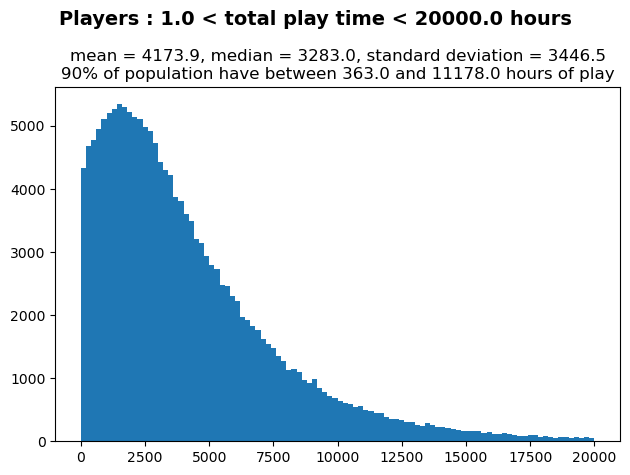

In [9]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

min_playtime, max_playtime = 1.0, 20_000.0

query = """SELECT total_hours FROM [steam_players].[dbo].[nonzero_players] ORDER BY total_hours DESC"""

all_total_times = pl.read_database(query=query, connection=engine.connect()).to_numpy().reshape(-1)
total_times = all_total_times[all_total_times > min_playtime]
total_times = total_times[total_times < max_playtime]
total_times

fig, ax = plt.subplots(1, sharey=True, tight_layout=True)
ax.hist(total_times, bins=100)
fig.suptitle(f'Players : {min_playtime} < total play time < {max_playtime} hours', fontsize=14, fontweight='bold')
stats_string = f"""mean = {np.mean(total_times):.1f}, median = {np.median(total_times):.1f}, standard deviation = {np.std(total_times):.1f}
90% of population have between {np.percentile(total_times,5):.1f} and {np.percentile(total_times,95):.1f} hours of play"""
ax.set_title(stats_string)
plt.show()

In [6]:
import polars as pl

min_playtime, max_playtime = 1.0, 10_000.0

query = f"""SELECT profile_code, total_hours FROM [steam_players].[dbo].[nonzero_players]
WHERE  {min_playtime} < total_hours AND total_hours <= {max_playtime} 
ORDER BY total_hours DESC"""

cut_player_list = pl.read_database(query=query, connection=engine.connect())
print(cut_player_list[:10])

shape: (10, 2)
┌──────────────┬─────────────┐
│ profile_code ┆ total_hours │
│ ---          ┆ ---         │
│ i64          ┆ i64         │
╞══════════════╪═════════════╡
│ 176197       ┆ 10000       │
│ 315487       ┆ 10000       │
│ 429889       ┆ 10000       │
│ 77804        ┆ 9999        │
│ 345511       ┆ 9999        │
│ 145956       ┆ 9999        │
│ 358230       ┆ 9999        │
│ 410466       ┆ 9998        │
│ 80789        ┆ 9998        │
│ 350367       ┆ 9998        │
└──────────────┴─────────────┘


#### Sampling distribution ( replicating the distribution -not neccesary- sampling produces similar distribution)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(12345)

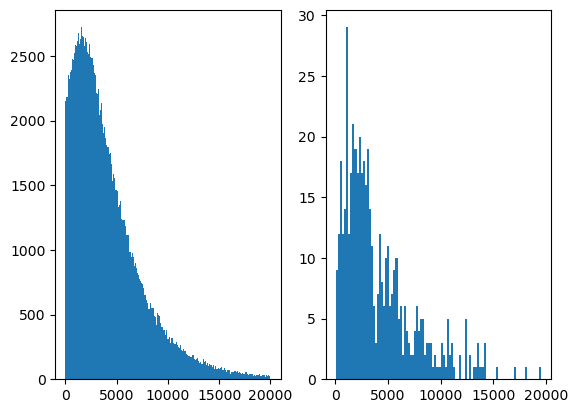

In [10]:

hist, bins = np.histogram(total_times, range=(0,20_000), bins=200)
bin_midpoints = bins[:-1] + np.diff(bins)/2

cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]    # normalised

values = rng.random(500)
value_bins = np.searchsorted(cdf, values)
random_from_cdf = bin_midpoints[value_bins]

plt.subplot(121)
plt.hist(total_times, 200)
plt.subplot(122)
plt.hist(random_from_cdf, 100)
plt.show()

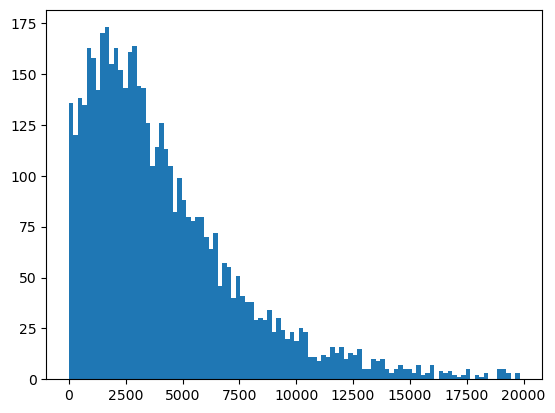

In [17]:
sample = rng.choice(a=total_times, size=5000)
samp_hist, sample_bins = np.histogram(sample, range=(0,20_000), bins=200)

plt.hist(sample, 100)
plt.show()

#### Piecewise linear distribution inversion

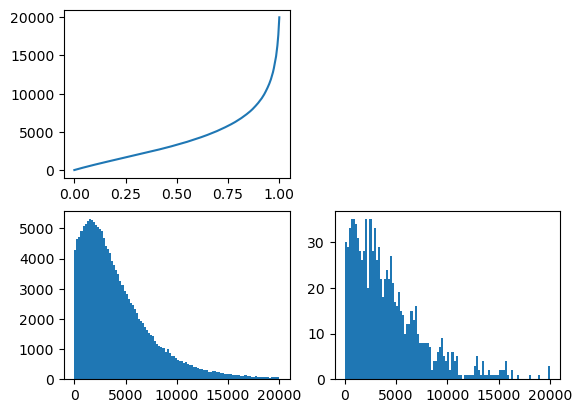

In [64]:
hist, bins = np.histogram(total_times, range=(0,20_000), bins=200)
bin_midpoints = bins[:-1] + np.diff(bins)/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]
cdf_y = np.append(0, cdf)

# y=x symmetry (assume no empty bins)
x, y = cdf_y, bins

# Plot
plt.subplot(221)
plt.plot(x, y)

# Piecewise linear between points:
sample_size = 1_000
uniform_01_sample = rng.random(sample_size)
hist_distr_sample = np.interp(uniform_01_sample, x, y)

plt.subplot(223)
plt.hist(total_times, 100)
plt.subplot(224)
plt.hist(hist_distr_sample, 100)

plt.show()

#### 1 < hours(player) < 20K

In [13]:
import polars as pl

query = """SELECT profile_code,total_hours FROM [steam_players].[dbo].[nonzero_players]
WHERE total_hours < 20000 AND total_hours > 1"""

pl.read_database(query=query, connection=engine.connect())

profile_code,total_hours
"decimal[28,0]",i64
304372,18059
410855,2581
324256,5356
158635,5338
175501,1772
…,…
443086,750
215968,967
37816,100


### Total game times

In [3]:
# columns: hours_on_record, hours_last_2_weeks, profile_code, game_name
import polars as pl

query = """SELECT game_code, SUM(hours_on_record) AS game_time
FROM [steam_players].[dbo].[games_data]
GROUP BY game_code
HAVING SUM(hours_on_record) > 0
ORDER BY SUM(hours_on_record) DESC;"""

games_time = pl.read_database(query=query, connection=engine.connect())
# print(games_time[:10])
# gt_times = games_time["game_time"].to_numpy()
# gt_times[gt_times==1].sum()

In [5]:
games_time[:10]#['game_code'].to_numpy()

game_code,game_time
i64,i64
8025,242830446
8449,62745203
18723,26610802
52848,18369653
57411,18364803
40000,15865255
50438,15085000
45705,14728386
54197,10604639


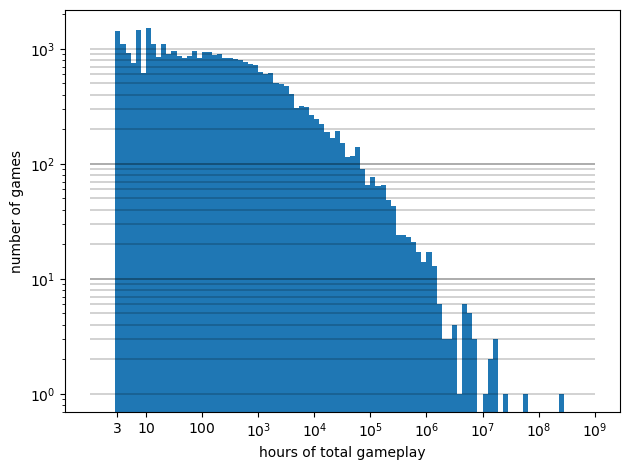

In [4]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(12345)

gt_times = games_time["game_time"].to_numpy()
gt_times = gt_times[gt_times > 2]

gt_bins = [10**i for i in np.linspace(start=0, stop=9, num=100)]
gt_hist, gt_bins = np.histogram(gt_times, bins=gt_bins)

# horizontal bars levels
orders = np.array([10**i for i in range(3)]).reshape(-1,1)
digits = np.arange(1,11,1)
y_vals = (orders * digits).flatten()

fig, ax = plt.subplots(1, sharey=True, tight_layout=True)

ax.set_xscale('log')
ax.set_xlabel('hours of total gameplay')
plt.xticks(
    ticks=[3, 10, 100, 10**3, 10**4, 10**5, 10**6, 10**7,10**8, 10**9],
    labels=['$3$', '$10$', '$100$',"$10^3$","$10^4$","$10^5$","$10^6$","$10^7$","$10^8$","$10^9$"]
    )

ax.set_yscale('log')
ax.set_ylabel('number of games')

ax.stairs(gt_hist, gt_bins, fill=True,)
ax.hlines(y_vals, xmin=1, xmax=10**9, colors='black', linewidth=0.25)
plt.show()

# N games with M players with x of their time in those N games
Let \
$\quad\Omega$ be the set of all games, \
$\quad\Gamma$ be the set of all players, \
$\quad x \in [0,1]$\
For given $G \subset \Omega$, let $P(G) \subset\Gamma$, such that: \
    $\quad \forall p\in P(G) \quad x*\text{playtime}(p,\Omega)\geq\text{playtime}(p,G)$.

Players in $P(G)$ have more than $x$ of their total playtime in games from subset $G$

In [77]:
## table of player times to polars:
import polars as pl

# query = """SELECT * FROM steam_players.dbo.players_times"""

# players_times = pl.read_database(query=query, connection=engine.connect())

In [20]:
## Subset of games:
G = list(games_time['game_code'][:5])
G

[8025, 8449, 18723, 52848, 57411]

## string parsing for a sql query

In [9]:
from query_generators.generators import query_for_gamecodes
print(query_for_gamecodes(code_list=[8025, 8449, 18723]))

WITH 
	g0 AS (
	SELECT TOP 10000 profile_code, hours_on_record
	FROM steam_players.dbo.games_data
	WHERE game_code = 1
	),
	g1 AS (
	SELECT TOP 10000 profile_code, hours_on_record
	FROM steam_players.dbo.games_data
	WHERE game_code = 2
	),
	union_of_profile_codes AS (
	SELECT profile_code FROM g0
	UNION
	SELECT profile_code FROM g1
	)
SELECT
	union_of_profile_codes.profile_code AS profile_code,
	COALESCE(g0.hours_on_record, 0) AS game_0,
	COALESCE(g1.hours_on_record, 0) AS game_1
FROM
	union_of_profile_codes
LEFT JOIN g0
ON union_of_profile_codes.profile_code = g0.profile_code
LEFT JOIN g1
ON union_of_profile_codes.profile_code = g1.profile_code;


In [7]:
example_list = [8025, 8449, 18723, 52848, 57411]
# print(query_for_gamecodes(example_list))

In [69]:
import polars as pl

query = query_for_gamecodes(example_list)

four_games = pl.read_database(query=query, connection=engine.connect())

In [75]:
four_games.select(pl.exclude("profile_code")).to_numpy()

array([[1683,    0,    0,  356,    0],
       [1668,    0,    0,    0,  300],
       [   0,    0,    0,    0,    0],
       ...,
       [   0,    0,    0,    0,    0],
       [   0,    0,   17,    0,    0],
       [   0,    0,    0, 1274,    0]], dtype=int64)

In [29]:
def column_headers_string(input_list):
    # test: column_headers_string(['A','B','C'])
    return ', '.join(f"ISNULL([{item}], 0) AS G{index}" for index, item in enumerate(input_list))
def where_games_list(input_list):
    #test: where_games_list(['A[]','B()','C'])
    return f"""('{"','".join(input_list)}')"""
def pivot_game_list(input_list):
    return "("+", ".join([f"[{game}]" for game in ['A[]','B()','C']])+")"

def profile_for_game_list(num_of_players, game_list):
    
    part_0 = f"SELECT TOP {num_of_players} profile_code, "
    part_1 = "FROM (SELECT * FROM steam_players.dbo.players_times WHERE game_name IN "
    part_2 = ") AS SourceTable PIVOT ( MAX(hours_on_record) FOR game_name IN "
    part_3 = ") AS PivotTable;"
    between_0_1 = column_headers_string(game_list)
    between_1_2 = where_games_list(game_list)
    between_2_3 = pivot_game_list(game_list)
    
    final_query = part_0 + between_0_1 + part_1 + between_1_2 + part_2 + between_2_3 +part_3
    return final_query

profile_for_game_list(14, ['Team Fortress 2',"Garry's Mod",'Counter-Strike 2'])




"SELECT TOP 14 profile_code, ISNULL([Team Fortress 2], 0) AS G0, ISNULL([Garry's Mod], 0) AS G1, ISNULL([Counter-Strike 2], 0) AS G2FROM (SELECT * FROM steam_players.dbo.players_times WHERE game_name IN ('Team Fortress 2','Garry's Mod','Counter-Strike 2')) AS SourceTable PIVOT ( MAX(hours_on_record) FOR game_name IN ([A[]], [B()], [C])) AS PivotTable;"

In [26]:
"("+", ".join([f"[{game}]" for game in ['A[]','B()','C']])+")"

'([A[]], [B()], [C])'

# Tosia Part

In [5]:
import numpy as np
import random 

n_rows = 50
n_cols = 250
rank = 3

x = np.random.default_rng().normal(size=(n_rows, rank)) 
y = np.random.default_rng().normal(size=(rank, n_cols)) 
M = np.dot(x, y)

M_incomplete = np.copy(M)
num_missing_elements = int(0.7 * M.size)
indices_to_zero = random.sample(range(M.size), k=num_missing_elements)
rows, cols = np.unravel_index(indices_to_zero, M.shape)
M_incomplete[rows, cols] = np.nan

In [2]:
from csmc import CSMC
solver = CSMC(M_incomplete, col_number=100)
M_filled = solver.fit_transform(M_incomplete)

In [3]:
from csmc import NuclearNormMin
solver = NuclearNormMin(M_incomplete)
M_filled = solver.fit_transform(M_incomplete, np.isnan(M_incomplete))
# np.linalg.norm(M-M_filled)
# np.linalg.norm(M_incomplete)

#### Completeing one column

In [52]:
n_rows = 50
n_cols = 250
rank = 3

x = np.random.default_rng().normal(size=(n_rows, rank))**2
y = np.random.default_rng().normal(size=(rank, n_cols))**2
M = np.dot(x, y)

# Column of almost nan's:
a = np.empty((50,1))
a[:] = np.nan
a[0,0] = 10

M_incomplete = np.hstack([M,a])

from csmc import NuclearNormMin
solver = NuclearNormMin(M_incomplete)
M_filled = solver.fit_transform(M_incomplete, np.isnan(M_incomplete))

In [5]:
from csmc import NuclearNormMin
import numpy as np

# 50 most popular games :
num_of_games = 50
game_codes = games_time[:num_of_games]["game_code"].to_numpy()

# query = query_for_gamecodes(game_codes)

# table = pl.read_database(query=query, connection=engine.connect())
# print(query_for_gamecodes(game_codes))



# beh_source = four_games.select(pl.exclude("profile_code")).to_numpy()
# M_incomplete = np.vstack([beh_source, a])

In [6]:
query = query_for_gamecodes(game_codes)

source_table = pl.read_database(query=query, 
                                connection=engine.connect(),
                                schema_overrides={"profile_code" : pl.Int32})
%store source_table

Stored 'source_table' (DataFrame)


In [1]:
import polars as pl
import numpy as np
%store -r


In [2]:
map_dict = {0 : np.nan}
table = source_table.with_columns(sum=pl.sum_horizontal(pl.all().exclude("profile_code")))
table = table.with_columns(pl.all().exclude("profile_code","sum").replace(map_dict))

In [3]:
M_incomplete = table.sort(by="sum", descending=True).select(pl.all().exclude("profile_code","sum")).to_numpy()[:100]
row_Q = np.array([[np.nan for i in range(50)]])
row_Q[0,0] = 300 
row_Q[0,1] = 200 
row_Q[0,2] = 100 
M_with_Q = np.vstack([M_incomplete,row_Q]).T

In [4]:
from csmc import CSMC
solver = CSMC(M_with_Q, col_number=100)
M_filled = solver.fit_transform(M_with_Q)

# from csmc import NuclearNormMin
# solver = NuclearNormMin(M_with_Q)
# M_filled = solver.fit_transform(M_with_Q, np.isnan(M_with_Q))

In [26]:
M_with_Q[np.isnan(M_with_Q)==False].shape

(632,)